# KMC simulation of PLD with Deep Q Learning

In this version the state function is just the atomic positions of the surface projection (flattened)

In [1]:
#!pip install tensorflow keras

In [2]:
#!pip install tensorflow-gpu

In [3]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
    
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    
    return surface_proj.flatten(), -1*rms_val

def run_sim_with_chosen_action(s,action,old_rate, new_rates, verbose=False):
    #Given simulation model and the action, update the rate and continue running the simulation
    
    #update the rates based on the action taken
    
    #new_rate = new_rates[action]
    '''if action<4
        new_dep_rate = new_rate
        new_diff_rate = old_rates[0]
    else:
        new_diff_rate = new_rate
        new_dep_rate = old_rates[1]'''
    new_diff_rate = old_rate[1]
    new_dep_rate = new_rates[action]
    
    s.update_rate(np.array([new_dep_rate, new_diff_rate]), verbose=verbose)
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99))
    
    #Now get the state and reward
    state, reward = get_state_reward(s)
            
    return state, reward, s,end_flag

In [5]:
#Need to hold the state in memory and hten 

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [8]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [9]:
wdir = '../data/working'

In [10]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [11]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [12]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [13]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [14]:
sim = RunSim()
sim.read(os.path.join(wdir,'kmc.input'))
sim.init_sim()
sim.run()

('Number of events:', array([512,   0]))
(30.005205293348553, 3346, 3280)


('Number of events:', array([512,   0]))
current rates:[0.1 0.1] 
new rates:[0.12 0.12]
('kmc step:', 0)
('Number of events:', array([512,   0]))
current rates:[0.1 0.1] 
new rates:[0.14 0.12]
('kmc step:', 0)
('Number of events:', array([512,   0]))
current rates:[0.1 0.1] 
new rates:[0.16 0.12]
('kmc step:', 0)


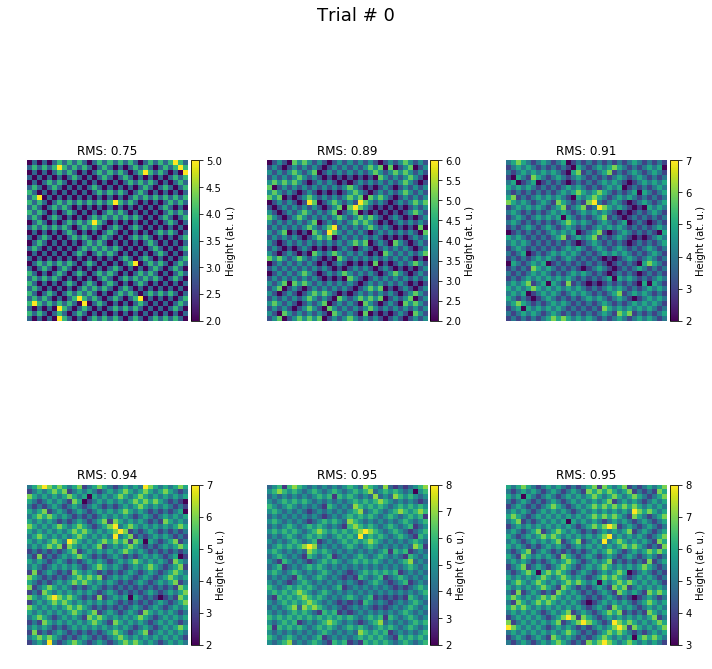

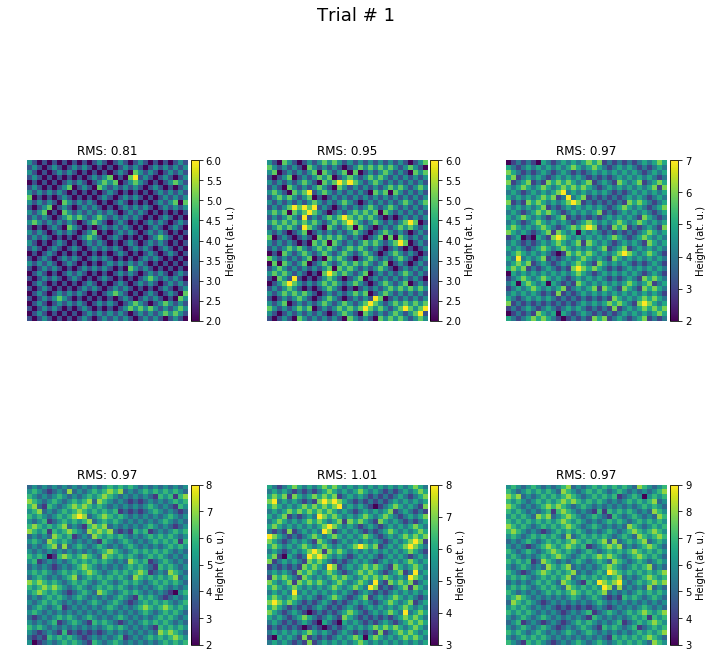

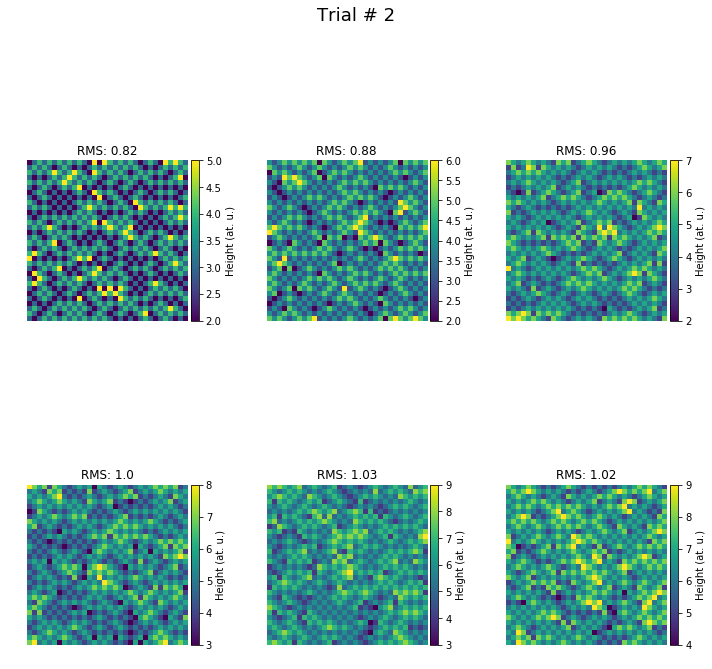

In [15]:
drates = [0.12, 0.14, 0.16]
deprates = [0.12, 0.12, 0.12]

arrs = []
roughness_values = []
for k in range(3):

    sim = RunSim()
    sim.read(os.path.join(wdir,'kmc.input'))
    sim.init_sim()
    sim.update_rate(np.array([drates[k], deprates[k]]))
    fig, axes = plt.subplots(figsize = (10,10), nrows=2,ncols=3)
    fig.suptitle("Trial # {}".format(k), fontsize = 18, y = 1.05)
    for ind, ax in enumerate(axes.flat):

        sim.run_to_next_step()
        arr = sim.kmc.get_conf()
        arr_1 = np.array(arr[0])
        arrs.append(arr_1)
        full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
        for i,j,k in arr_1:
            full_atom_box[i,j,k]=1

        surface_proj = make_surface_proj(full_atom_box)
        rms_val = calc_roughness(surface_proj)
        roughness_values.append(rms_val)
        im1 = ax.imshow(surface_proj)
        #plt.colorbar()
        ax.set_title('RMS: ' + str(np.round(rms_val,2)));
        ax.axis('off')
        #ax.set_yticklabels('')
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(im1, cax=cax, orientation='vertical')
        cb.ax.set_ylabel('Height (at. u.)')
        
    fig.tight_layout(h_pad = 1.12, w_pad = 1.12)
    


In [16]:
arr = sim.kmc.get_conf()
arr_1 = np.array(arr[0])

In [17]:
arr_1.shape

(4203, 3)

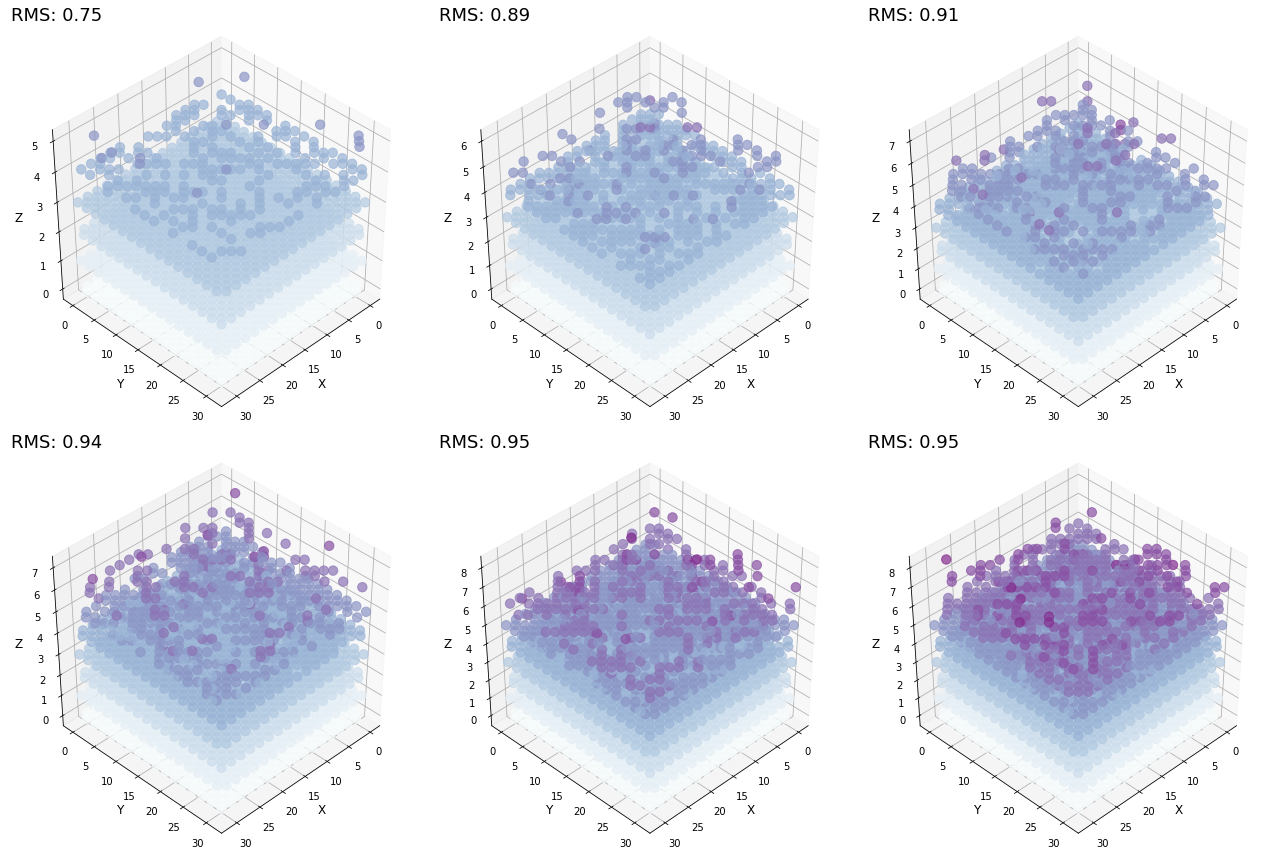

In [18]:
colors = plt.cm.get_cmap('BuPu', arr_1[:,2].max()*1.25)
arr_1 = arrs[5]

fig2, axes2 = plt.subplots(figsize = (18,12),nrows=2,ncols=3,subplot_kw=dict(projection='3d'))
for ind, ax in enumerate(axes2.flat):
    roughness_val = np.round(roughness_values[ind],2)
    arr_1 = arrs[ind]
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(arr_1[:,0],arr_1[:,1],arr_1[:,2],s=88, alpha = 0.7, c = colors(arr_1[:,2]) )
    ax.view_init(40, 45)
    ax.set_xlabel('X', fontsize = 12)
    ax.set_ylabel('Y', fontsize = 12)
    ax.set_zlabel('Z', fontsize = 12)
    ax.set_title('RMS: {}'.format(roughness_val), loc = 'left', fontsize = 18)
fig2.tight_layout()

Text(0.5,1,'Roughness as Func. of Deposition Rates')

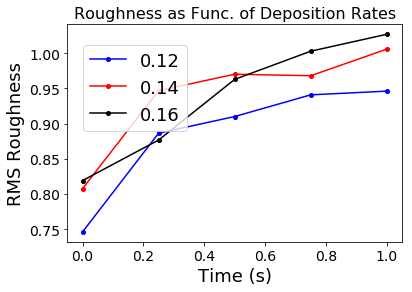

In [19]:
time_vec = np.linspace(0,1,5)

fig, axes = plt.subplots()
axes.plot(time_vec, roughness_values[:5], color = 'b', markersize = 4, marker = 'o',label = drates[0])
axes.plot(time_vec, roughness_values[6:11], color = 'r', markersize = 4, marker = 'o',label = drates[1])
axes.plot(time_vec, roughness_values[12:-1], color = 'k', markersize = 4, marker = 'o',label = drates[2])
axes.set_xlabel('Time (s)', fontsize = 18)
axes.set_ylabel('RMS Roughness', fontsize = 18)
fig.legend(loc=[0.2, 0.55], fontsize= 18)
for tickx in axes.xaxis.get_major_ticks():
    tickx.label.set_fontsize(14) 
for ticky in axes.yaxis.get_major_ticks():
    ticky.label.set_fontsize(14) 
axes.set_title('Roughness as Func. of Deposition Rates', fontsize = 16)
    

# Reinforcement Learning Trial

In [20]:
#Set up the neural network model. Input: atom position box. Output: Choose out of 5 deposition rates ([0.05, 0.1, 0.15, 0.20, 0.25])
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Conv3D, MaxPool3D, Flatten
from keras.optimizers import SGD

model = Sequential()
model.add(InputLayer(input_shape=(32*32,1), batch_size=1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.build()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (1, 1024)                 0         
_________________________________________________________________
dense_1 (Dense)              (1, 256)                  262400    
_________________________________________________________________
dense_2 (Dense)              (1, 256)                  65792     
_________________________________________________________________
dense_3 (Dense)              (1, 128)                  32896     
_________________________________________________________________
dense_4 (Dense)              (1, 4)                    516       
Total params: 361,604
Trainable params: 361,604
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_episodes = 250
y = 0.50
eps = 0.8
decay_factor = 0.97
r_avg_list = []
dep_rates = [0.12, 0.14, 0.16, 0.18]
diff_rates = [0.12, 0.14, 0.16, 0.18]
all_rates = [0.12, 0.14, 0.16, 0.18, 0.12, 0.14, 0.16, 0.18]
action_chosen = []

s = RunSim()
s.read(os.path.join(wdir,'kmc.input')) #Initialize the simulation with this input
    
for episode in range(num_episodes):
    if episode%100==0:
        print('Episode No. {}'.format(episode))
        
    counter = 0
    r_sum = 0
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    
    s.init_sim()
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99)) #Run the simulation from the initial conditions
    
    while end_flag!=1:
        t0 = time()
        eps *= decay_factor
        #eps = max(eps, 0.05) #maintain some semblence of exploration ;)
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        if np.random.random() < eps:
            action = np.random.randint(0, 4)
        else:
            action = np.argmax(model.predict(state[None,:,None]))

        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        old_rates = s.kmc.etree.rates
        s_new, reward_new, kmc_model, end_flag = run_sim_with_chosen_action(s,action,old_rates, dep_rates)
        
        reward_new = reward_new - reward 
        
        target = reward_new + y * np.max(model.predict(s_new[None,:,None]))
        target_vec = model.predict(state[None,:,None])[0]
        target_vec[action] = target
        
        #print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))
        
        model.fit(state[None,:,None], target_vec.reshape(-1, 4), epochs=1, verbose=0)
        s = kmc_model
        counter+=1
        r_sum += reward_new
        
        t1 = time()
        action_chosen.append(action)
        #print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(r_sum)


Episode No. 0
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('Number of events:', array([512,   0]))
('

KeyboardInterrupt: 

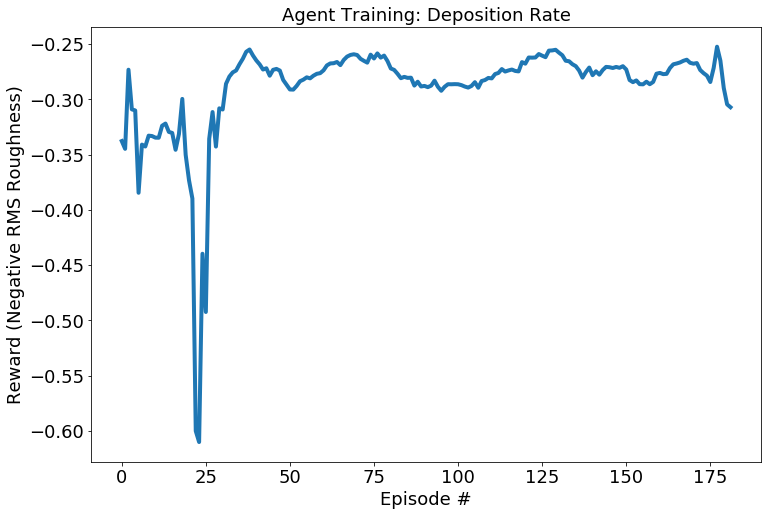

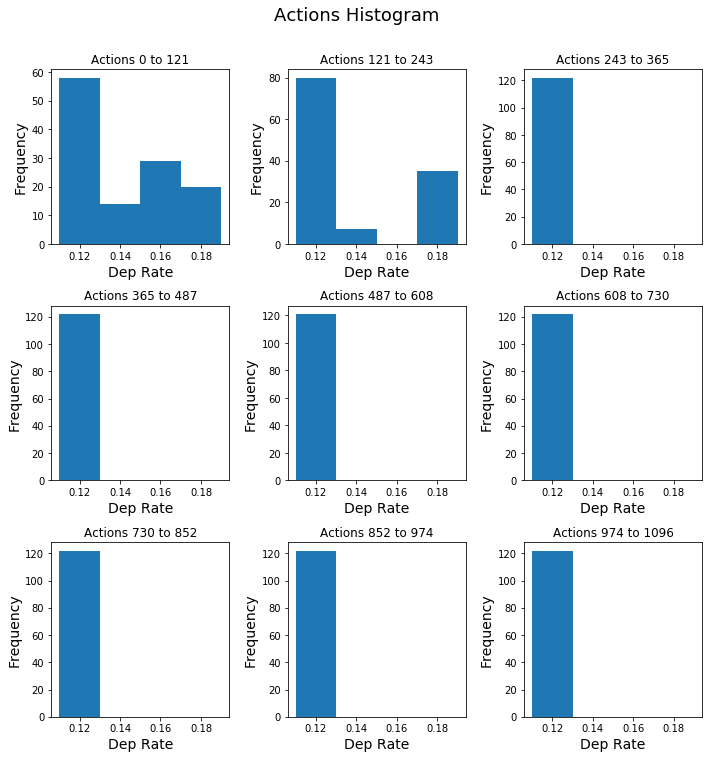

In [22]:
from scipy.signal import wiener

kernel_size = 13

plt.figure(figsize = (12,8))
plt.plot(wiener(r_avg_list, mysize = kernel_size)[:], linewidth = 4)
plt.title('Agent Training: Deposition Rate', fontsize = 18)
plt.xlabel('Episode #', fontsize = 18)
plt.ylabel('Reward (Negative RMS Roughness)', fontsize = 18)
plt.xticks(fontsize =18)
plt.yticks(fontsize =18)
plt.savefig('reward_per_episode_dep_sp_flat.png', dpi = 300)

#Let's take a look at how the actions change over time: consider 9 increments

total_actions = len(action_chosen)
segments = np.linspace(0,total_actions, 10)

fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))
for ind, ax in enumerate(axes.flat):
    seg_start = int(segments[ind])
    seg_finish = min(int(segments[ind+1]),total_actions)
    act_segment = action_chosen[seg_start:seg_finish]    
    ax.hist(act_segment, bins = [0,1,2,3,4])
    ax.set_xlabel('Dep Rate', fontsize = 14)
    ax.set_ylabel('Frequency', fontsize = 14)
    ax.set_title('Actions {} to {}'.format(seg_start, seg_finish), fontsize = 12 )
    ax.set_xticks([0.5,1.5,2.5,3.5])
    ax.set_xticklabels(dep_rates)

fig.suptitle('Actions Histogram', fontsize = 18, y = 1.05)
fig.tight_layout()
fig.savefig('actions_histogram_dep_sp_flat.png', dpi = 300)

In [ ]:
# Run the simulator with different values of the rates to establish baseline performance

In [ ]:
for q in q_predictions: print(q[0])

In [ ]:
plt.figure()
plt.imshow(sim_results_meaned[:,:,0])
plt.colorbar(label = '-1*Roughness RMS')
plt.xticks([0,1,2,3], diff_rates, fontsize = 14)
plt.yticks([0,1,2,3],dep_rates, fontsize = 14)
plt.xlabel('Diffusion Rates', fontsize = 18)
plt.ylabel('Deposition Rates', fontsize = 18)
plt.title('Mean of 30 runs', fontsize = 18)

plt.figure()
plt.imshow(sim_results_meaned[:,:,1])
plt.colorbar(label = '-Std. Dev. of Reward')
plt.xticks([0,1,2,3], diff_rates, fontsize = 14)
plt.yticks([0,1,2,3],dep_rates, fontsize = 14)
plt.xlabel('Diffusion Rates', fontsize = 18)
plt.ylabel('Deposition Rates', fontsize = 18)
plt.title('Stdev of 30 runs', fontsize = 18)


#### things to try
#1. 2d conv net with surface projection
#2. flattened array with xyz values instead of whole box
#3. find time taken per simulation (as above)

1. distributed learning.
2. try more sophisticated algo.
3. keep on getting closer to PLD...
